In [25]:
import cv2
import numpy as np
import numpy.matlib
import math
import utils
from plyfile import PlyData, PlyElement
import subprocess
import matplotlib.pyplot as plt
import os
import json
import statistics
%matplotlib notebook
pi = 3.14159265
size0 = 1024
maxdisp = 192

def xyz2pc (XYZ, im, mask):
    pcdt = np.dtype([('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
    fa = np.empty(len(mask[mask>0]), dtype=pcdt)
    i = 0
    for x in range(0, XYZ.shape[1]):
        for y in range(0, XYZ.shape[0]):
            if (mask[y,x]==1):
                fa[i] = np.array([(XYZ[y,x,0], XYZ[y,x,1], XYZ[y,x,2], im[y,x,0], im[y,x,1], im[y,x,2])], dtype=pcdt)
                i = i + 1
    return fa

def xyz2pc4p3d(surface, im, mask):
    pcdt = np.dtype([('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])
    fa = np.empty(len(mask[mask>0]), dtype=pcdt)
    i = 0
    for x in range(0, surface.shape[1]):
        for y in range(0, surface.shape[0]):
            if (mask[y,x]==1):
                fa[i] = np.array([(y, x, surface[y,x], im[y,x,0], im[y,x,1], im[y,x,2])], dtype=pcdt)
                i = i + 1
    return fa

def call_PSMNet(imgL_path, imgR_path, disp_path, maxdisp = 192, imsize = 1024, mirror=0):
    # Calling PSMNet (https://github.com/JiaRenChang/PSMNet) to reconstruct stereo disparity map

    command = ['python2', 'PSMNet/PSMNet_stereo.py', 
               '--maxdisp', str(maxdisp), 
               '--loadmodel', 'PSMNet/models/pretrained_model_KITTI2015.tar', 
               '--imgL', imgL_path, 
               '--imgR', imgR_path, 
               '--out', disp_path, 
               '--imsize', str(imsize),
               '--mirror', str(mirror)]
    subprocess.call(command)
    
def run_openpose(imdir, outdir):
    command = ['/home/vaheta/builds/openpose/build/examples/openpose/openpose.bin', 
            '--image_dir', imdir, 
            '--face', 
            '--net_resolution', '656x368', 
            '--write_json', outdir,
            '--write_images', outdir,
            '--display', '0']
    subprocess.call(command)
    
def read_keypoint_json(jsonpath, rotate=False, ymax = 0):
    with open(jsonpath) as f:
        data = json.load(f)
        facedict = {'x':[], 'y':[], 'c':[]}
        # detect correct person first
        j0 = 0
        for j in range(0, len(data['people'])):
            csum = 0
            for i,k in enumerate(data['people'][j]['face_keypoints_2d']):
                if i%3==2:
                    csum = csum + k/(len(data['people'][j]['face_keypoints_2d'])/3)
            if csum > 0.5:
                j0 = j
        for i,k in enumerate(data['people'][j0]['face_keypoints_2d']):
            if rotate:
                if i%3==0:
                    facedict['y'].append(k)
                elif i%3==1:
                    facedict['x'].append(ymax-k-1)
                elif i%3==2:
                    facedict['c'].append(k)
            else:
                if i%3==0:
                    facedict['x'].append(k)
                elif i%3==1:
                    facedict['y'].append(k)
                elif i%3==2:
                    facedict['c'].append(k)
    return facedict

def color_correction(im, a):
    ymax = im.shape[0]
    xmax = im.shape[1]
    imout = np.zeros(im.shape)
    for y in range(0,ymax):
        for x in range(0,xmax):
            r = int(im[y,x,0])
            g = int(im[y,x,1])
            b = int(im[y,x,2])
            vec = np.array([r,g,b,r**2,g**2,b**2,r*g,r*b,b*g,r**3,g**3,b**3,(r**2)*g,r*(g**2),(r**2)*b,r*(b**2),(b**2)*g,b*(g**2)])
            rgbnew = np.dot(vec,a.T)
            imout[y,x,:] = np.around(rgbnew)
    return imout

In [2]:
def stacker(lFrame, rFrame, calp, rotate=False):
    
    ### RECTIFYING IMAGES AND SAVING RESULTING IMAGES
    img_shape = lFrame[:,:,0].shape[::-1]
    (RCT1, RCT2, P1, P2, dsp2dm, ROI1, ROI2) = cv2.stereoRectify(
            calp['M1'], calp['d1'],
            calp['M2'], calp['d2'],
            img_shape, calp['R'], calp['T'],
            None, None, None, None, None,
            cv2.CALIB_ZERO_DISPARITY, alpha=-1)

    leftMapX, leftMapY = cv2.initUndistortRectifyMap(
            calp['M1'], calp['d1'], RCT1,
            P1, img_shape, cv2.CV_32FC1)
    rightMapX, rightMapY = cv2.initUndistortRectifyMap(
            calp['M2'], calp['d2'], RCT2,
            P2, img_shape, cv2.CV_32FC1)

    fixedLeft = cv2.remap(lFrame, leftMapX, leftMapY, cv2.INTER_LINEAR)
    fixedRight = cv2.remap(rFrame, rightMapX, rightMapY, cv2.INTER_LINEAR)

#     if rotate:
#         fixedLeft = np.flipud(np.rot90(fixedLeft,3))
#         fixedRight = np.flipud(np.rot90(fixedRight,3))
#         img_shape = fixedRight[:,:,0].shape[::-1]
    
    imgL_path = 'rectified/rect_l.png'
    imgR_path = 'rectified/rect_r.png'
    
    cv2.imwrite(imgL_path, fixedLeft)
    cv2.imwrite(imgR_path, fixedRight)
    
    
    ### SUBSTRACTING CONST DISPARITY VALUE (A HACK TO GET A HIGHER DISPARITY RESOLUTION)

    imdir = 'rectified/'
    run_openpose(imdir, imdir+'openpose_out/')

    filenamel, extensionl = os.path.splitext(os.path.basename(imgL_path))
    filenamer, extensionr = os.path.splitext(os.path.basename(imgR_path))
    
    if rotate:
        facepoints_l = read_keypoint_json((imdir+'openpose_out/'+filenamel+'_keypoints.json'), True, img_shape[1])
        facepoints_r = read_keypoint_json((imdir+'openpose_out/'+filenamer+'_keypoints.json'), True, img_shape[1])
        fixedLeft = np.rot90(fixedLeft,3)
        fixedRight = np.rot90(fixedRight,3)
        img_shape = fixedRight[:,:,0].shape[::-1]
    else:
        facepoints_l = read_keypoint_json((imdir+'openpose_out/'+filenamel+'_keypoints.json'))
        facepoints_r = read_keypoint_json((imdir+'openpose_out/'+filenamer+'_keypoints.json'))        
    
    diff = [0]*len(facepoints_l['x'])
    for i in range(0, len(facepoints_l['x'])):
        diff[i] = int(facepoints_l['x'][i] - facepoints_r['x'][i])
    dispwindow = max(diff)-min(diff)
    dispadd = maxdisp - 1*dispwindow
    if dispadd < 0:
        print ("ATTENTION! NEED TO TWEEK DISP HACK PARAMETERS")


    if rotate:
        k1 = 0.5
        k2 = 0.1
    else:
        k1 = 0.1
        k2 = 0.5
        
    min_x_lt = min(facepoints_l['x'])
    max_x_lt = max(facepoints_l['x'])
    min_y_lt = min(facepoints_l['y'])
    max_y_lt = max(facepoints_l['y'])

    min_x_l = int(min_x_lt - 0.1*(max_x_lt-min_x_lt))
    max_x_l = int(max_x_lt + k1*(max_x_lt-min_x_lt))
    min_y_l = int(min_y_lt - k2*(max_y_lt-min_y_lt))
    max_y_l = int(max_y_lt + 0.1*(max_y_lt-min_y_lt))

    min_x_rt = min(facepoints_r['x'])
    max_x_rt = max(facepoints_r['x'])
    min_y_rt = min(facepoints_r['y'])
    max_y_rt = max(facepoints_r['y'])

    min_x_r = int(min_x_rt - 0.1*(max_x_rt-min_x_rt))
    max_x_r = int(max_x_rt + k1*(max_x_rt-min_x_rt))
    min_y_r = int(min_y_rt - k2*(max_y_rt-min_y_rt))
    max_y_r = int(max_y_rt + 0.1*(max_y_rt-min_y_rt))

    deltadisp = (min_x_l-dispadd) - min_x_r
    
    imwidth = max([max_x_l - (min_x_l-dispadd), (max_x_r+dispadd) - min_x_r])
    
    iml = fixedLeft[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),:]
    imr = fixedRight[min_y_r:max_y_r, min_x_r:(min_x_r+imwidth),:]

    iml = cv2.resize(iml, (size0,size0))
    imr = cv2.resize(imr, (size0,size0))

    imgL_cut_path = 'rectified/rect_l_cut.png'
    imgR_cut_path = 'rectified/rect_r_cut.png'

    cv2.imwrite(imgL_cut_path, iml)
    cv2.imwrite(imgR_cut_path, imr)
    
    ### CALCULATING DISPARITY MAP

    disp_path = 'rectified/tempdispmap.npy'
    call_PSMNet(imgL_cut_path, imgR_cut_path, disp_path, imsize=size0, maxdisp=maxdisp)
    dispmap_load = np.load(disp_path)
    
    ### TRANSLATING DISPARITY TO DEPTH MAP

    dispmap_cut = cv2.resize(dispmap_load, (imwidth, (max_y_l-min_y_l)))
    dispmap_cut = (dispmap_cut*imwidth/size0) + deltadisp
    dispmap = cv2.resize(dispmap_cut, img_shape)/10000
    dispmap[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth)] = dispmap_cut
    if rotate:
        dispmap = -np.rot90(dispmap)
        img_shape = dispmap.shape[::-1]
#     return dispmapdsp2dm
    XYZ = cv2.reprojectImageTo3D(dispmap, dsp2dm)

    if rotate:
        dmtemp = np.flipud(np.rot90(XYZ,3))[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),2]
    else:
        dmtemp = XYZ[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth),2]
    
    laplacian = cv2.Laplacian(dmtemp,cv2.CV_32F)
    sobelx = cv2.Sobel(dmtemp,cv2.CV_32F,1,0,ksize=5)
    sobely = cv2.Sobel(dmtemp,cv2.CV_32F,0,1,ksize=5)

    filtermapx = np.zeros(dmtemp.shape)
    filtermapy = np.zeros(dmtemp.shape)
    filtermap = np.zeros(dmtemp.shape)

    filtermapx[abs(sobelx)<np.mean(abs(sobelx))] = 1
    filtermapy[abs(sobely)<np.mean(abs(sobely))] = 1
    filtermap = filtermapx*filtermapy

    if rotate:
        mask = np.zeros(img_shape, np.uint8)
        mask[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth)] = filtermap
        mask = np.rot90(mask)
    else:
        mask = np.zeros(img_shape[::-1], np.uint8)
        mask[min_y_l:max_y_l, (min_x_l-dispadd):(min_x_l-dispadd+imwidth)] = filtermap
    dispmap = dispmap*mask
    
    if rotate:
        dmrot = np.rot90(XYZ[:,:,2],3)
    else:
        dmrot = XYZ[:,:,2]
    facepoints_l['z'] = len(facepoints_l['x']) * [0]
    for i in range(0, len(facepoints_l['x'])):
        facepoints_l['z'][i] = dmrot[int(facepoints_l['y'][i]), int(facepoints_l['x'][i])]

    min_z_l = statistics.median(facepoints_l['z'])-100
    max_z_l = statistics.median(facepoints_l['z'])+100
    mask[XYZ[:,:,2]>max_z_l] = 0
    mask[XYZ[:,:,2]<min_z_l] = 0

    kernel = np.ones((9,9),np.uint8)
    mask = cv2.erode(mask,kernel,iterations = 2)
    
    maskoutn, maskout = cv2.connectedComponents(mask)
    max1 = 0
    imax = 0
    for i in range(1, maskoutn):
        if len(maskout[maskout==i])>max1:
            max1 = len(maskout[maskout==i])
            imax = i
    mask[maskout!=imax] = 0
    mask = cv2.dilate(mask,kernel,iterations = 2)
    
    return (XYZ, dispmap, mask, fixedLeft, fixedRight, leftMapX, leftMapY)

In [3]:
### RECTIFYING IMAGES AND SAVING RESULTING IMAGES

calr = np.load ('26.05/calib_lr.npz')
calt = np.load ('26.05/calib_lt.npz')
colcal = np.load('26.05/color_calib.npz')
lFrame = cv2.imread('26.05/for_rectification/left.png')
rFrame = cv2.imread('26.05/for_rectification/right.png')
tFrame = cv2.imread('26.05/for_rectification/top.png')

# rFrame = color_correction(rFrame,colcal['ar'])
# tFrame = color_correction(tFrame,colcal['at'])

# cv2.imwrite('26.05/for_rectification/right_cc.png', rFrame)
# cv2.imwrite('26.05/for_rectification/top_cc.png', tFrame)

# lFramelayer = cv2.cvtColor(lFrame, cv2.COLOR_BGR2GRAY)
# rFramelayer = cv2.cvtColor(np.uint8(rFrame), cv2.COLOR_BGR2GRAY)
# tFramelayer = cv2.cvtColor(np.uint8(tFrame), cv2.COLOR_BGR2GRAY)

# for i in range(0,3):
#     lFrame[:,:,i] = lFramelayer
#     rFrame[:,:,i] = rFramelayer
#     tFrame[:,:,i] = tFramelayer

In [4]:
XYZlr, dispmaplr, masklr, fixedLeftlr, fixedRightlr, leftMapXlr, leftMapYlr = stacker(lFrame, rFrame, calr, False)
XYZlt, dispmaplt, masklt, fixedLeftlt, fixedRightlt, leftMapXlt, leftMapYlt = stacker(lFrame, tFrame, calt, True)

In [5]:
# Creating polarization 3dmap

ymax = lFrame.shape[0]
xmax = lFrame.shape[1]
fullmask = np.zeros((ymax, xmax, 2))
pol3d = np.zeros((ymax, xmax, 3))
pol3dunr = np.zeros((ymax, xmax, 3))
dmstack = np.zeros((ymax,xmax,2))
xstack = np.zeros((ymax,xmax,2))
ystack = np.zeros((ymax,xmax,2))

fixedRightlt1 = np.rot90(fixedRightlt)

for y in range (0,ymax):
    for x in range(0,xmax):
        if masklr[y,x] == 1:
            dx = dispmaplr[y,x]
            x1 = int(round(x - dx,0))
            pol3dunr[y,x,1] = fixedRightlr[y,x1,0]
        
        if masklt[y,x] == 1:
            dy = dispmaplt[y,x]
            y1 = int(round(y - dy,0))
            pol3dunr[y,x,2] = fixedRightlt1[y1,x,0]
            
for y in range (0,ymax):
    for x in range(0,xmax):
        ylr = int(round(leftMapYlr[y,x], 0))
        if ((ylr>=ymax) or (ylr<0)):
            continue
            
        xlr = int(round(leftMapXlr[y,x], 0))
        if ((xlr>=xmax) or (xlr<0)):
            continue
            
        ylt = int(round(leftMapYlt[y,x], 0))
        if ((ylt>=ymax) or (ylt<0)):
            continue
            
        xlt = int(round(leftMapXlt[y,x], 0))
        if ((xlt>=xmax) or (xlt<0)):
            continue
            
        if masklr[y,x] == 1:
            fullmask[ylr,xlr,0] = 1
            pol3d[ylr,xlr,1] = pol3dunr[y,x,1]
            xstack[ylr,xlr,0] = XYZlr[y,x,0]
            ystack[ylr,xlr,0] = XYZlr[y,x,1]
            dmstack[ylr,xlr,0] = XYZlr[y,x,2]
            
        if masklt[y,x] == 1:
            fullmask[ylt,xlt,1] = 1
            pol3d[ylt,xlt,2] = pol3dunr[y,x,2]
            xstack[ylt,xlt,1] = XYZlt[y,x,0]
            ystack[ylt,xlt,1] = XYZlt[y,x,1]
            dmstack[ylt,xlt,1] = XYZlt[y,x,2]
        
        pol3d[y,x,0] = lFrame[y,x,0]

newmask = fullmask[:,:,0] + fullmask[:,:,1]

newmask[newmask<2] = 0
newmask[newmask==2] = 1

pol3dfin = np.zeros((ymax, xmax, 3))
pol3dfin[:,:,0] = pol3d[:,:,0]*newmask
pol3dfin[:,:,1] = pol3d[:,:,1]*newmask
pol3dfin[:,:,2] = pol3d[:,:,2]*newmask

xm = (xstack[:,:,0] + xstack[:,:,1])/2
ym = (ystack[:,:,0] + ystack[:,:,1])/2
dm = (dmstack[:,:,0] + dmstack[:,:,1])/2

xm = xm * newmask
ym = ym * newmask
dm = dm * newmask

In [6]:
n = 1.6
xvals = np.mat([pi/4, pi/2, 0])
phi, theta, ro = utils.polarimgs2norms(pol3dfin, xvals, n, newmask)

<IPython.core.display.Javascript object>


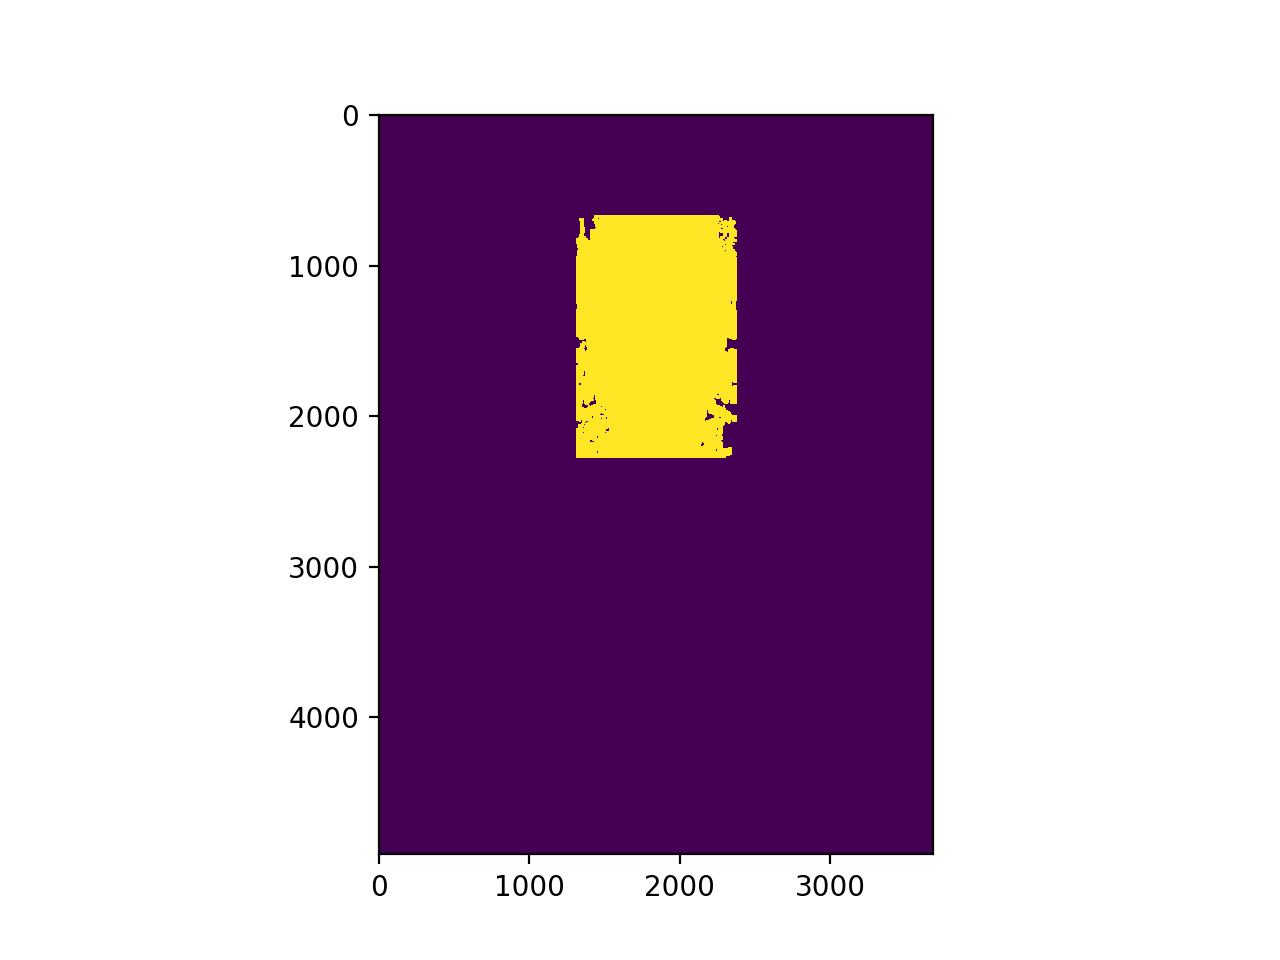

In [31]:
plt.figure()
plt.imshow(masklt)
# plt.clim(-500,500)
plt.show()

In [8]:
def get_kdtree_normals(XYZ0, objmask0, scale=1):
    H = int(XYZ0.shape[0]*scale)
    W = int(XYZ0.shape[1]*scale)
    XYZ = np.zeros((H,W,3))
    XYZ[:,:,0] = cv2.resize(XYZ0[:,:,0],(W,H))
    XYZ[:,:,1] = cv2.resize(XYZ0[:,:,1],(W,H))
    XYZ[:,:,2] = cv2.resize(XYZ0[:,:,2],(W,H))
    objmask = cv2.resize(objmask0,(W,H))
    N = np.zeros(XYZ0.shape)
    NX = np.zeros(XYZ[:,:,0].shape)
    NY = np.zeros(XYZ[:,:,0].shape)
    NZ = np.zeros(XYZ[:,:,0].shape)
    ymax = XYZ[:,:,0].shape[0]
    xmax = XYZ[:,:,0].shape[1]
    thrsh = 3
    r = 4
    view_point = np.array([0,0,0])
    for y in range(0, ymax):
        for x in range(0, xmax):
            if objmask[y,x]==0:
                continue
            nbhood = np.array([XYZ[y,x,0], XYZ[y,x,1], XYZ[y,x,2]])
            patch = XYZ[(y-r):(y+r),(x-r):(x+r),:]
            for i in range(0, (2*r)**2):
                yy = i//(2*r)
                xx = i%(2*r)
                if 0<abs(XYZ[y,x,2]-patch[yy,xx,2])<thrsh:
                    nbhood = np.vstack([nbhood, patch[yy,xx,:]])
            if nbhood.shape[0]>2:
                shnbhood = nbhood - numpy.matlib.repmat(np.mean(nbhood, axis=0),nbhood.shape[0],1)
                u, s, vh = np.linalg.svd(shnbhood, full_matrices=True)
                normal = vh[2,:]
                normal = np.divide(normal, np.linalg.norm(normal))
                if np.dot(normal,(view_point-XYZ[y,x,:])) < 0:
                    normal = -normal
                NX[y,x] = normal[0]
                NY[y,x] = normal[1]
                NZ[y,x] = -normal[2]
    N[:,:,0] = cv2.resize(NX,(XYZ0.shape[1], XYZ0.shape[0]))
    N[:,:,1] = cv2.resize(NY,(XYZ0.shape[1], XYZ0.shape[0]))
    N[:,:,2] = cv2.resize(NZ,(XYZ0.shape[1], XYZ0.shape[0]))
    return N

In [9]:
XYZm = np.zeros(XYZlr.shape)
XYZm[:,:,0] = xm
XYZm[:,:,1] = ym
XYZm[:,:,2] = dm
N = get_kdtree_normals(XYZm, newmask, 0.25)

In [10]:
azimuth = np.arctan2(-N[:,:,1],N[:,:,0])
zenith = np.arccos(N[:,:,2])

<IPython.core.display.Javascript object>


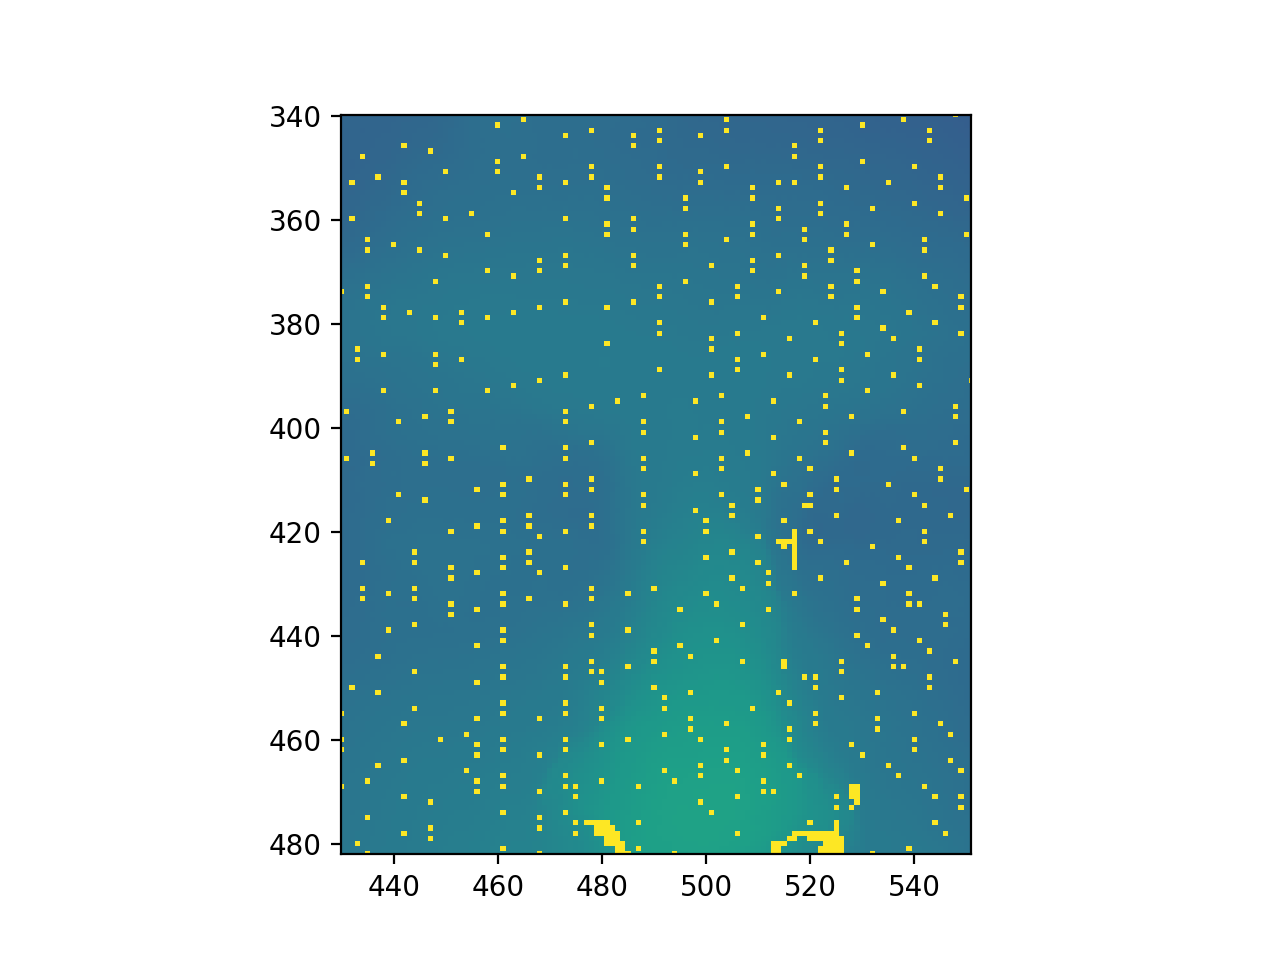

In [47]:
plt.figure()
plt.imshow(surface1)
plt.clim(0,200)
plt.show()
# np.uint8(N*255)

In [12]:
def fuser(phi, objmask, azimuth):
    r = 2
    ymax = phi.shape[0]
    xmax = phi.shape[1]
    ch_mask=np.zeros(phi.shape)
    phi_corr = phi.copy()
    for y in range(0,ymax):
        for x in range(0,xmax):
            if objmask[y,x]==0:
                continue
            phixy = phi[y,x]
            phi_patch = phi[(y-r):(y+r), (x-r):(x+r)]
            azimuth_patch = azimuth[(y-r):(y+r), (x-r):(x+r)]
            mask_patch = objmask[(y-r):(y+r), (x-r):(x+r)]

            error = np.linalg.norm(np.multiply(mask_patch, (phi_patch-azimuth_patch)))
            error_pi_minus = np.linalg.norm(np.multiply(mask_patch, (phi_patch-pi-azimuth_patch)))
            error_pi_plus = np.linalg.norm(np.multiply(mask_patch, (phi_patch+pi-azimuth_patch)))
            er = np.array([error, error_pi_minus, error_pi_plus])
            if (np.min(er)==abs(error_pi_minus)) and (phixy>=0):
                ch_mask[y,x] = 1
            elif (np.min(er)==abs(error_pi_plus)) and (phixy<=0):
                ch_mask[y,x] = 1  
            elif (abs(phixy-azimuth[y,x])>=2):
                ch_mask[y,x] = 1

            if (ch_mask[y,x] == 1):
                if (phixy>=0):
                    phi_corr[y,x] = phixy - pi
                elif (phixy<0):
                    phi_corr[y,x] = phixy + pi
    return phi_corr

In [13]:
def normals (phi, theta):
    ymax = phi.shape[0]
    xmax = phi.shape[1]
    norms = np.zeros((ymax,xmax,3))
    grad = np.zeros((ymax,xmax,3))
    one = np.ones((ymax,xmax))

    PX = np.multiply(np.cos(phi), np.sin(theta))
    PY = np.multiply(np.sin(phi), np.sin(theta))
    PZ = np.cos(theta)

    norms[:,:,0] = PX
    norms[:,:,1] = PY
    norms[:,:,2] = PZ

    grad[:,:,0] = np.divide(-PX, PZ)
    grad[:,:,1] = np.divide(-PY, PZ)
    grad[:,:,2] = -one

    return (grad, norms)

In [14]:
phi_corr = fuser(phi, newmask, azimuth)

In [15]:
(grad_corr, norms_corr) = normals(-phi_corr, theta)

In [42]:
dm = XYZm[:,:,2]

In [17]:
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def calculate_f_tensor(gx,gy,d11,d12,d21,d22):
    ymax = gx.shape[0]
    xmax = gx.shape[1] 

    gx1 = gx*d11
    gy1 = gy*d22

    gx1 = np.pad(gx1, 1, mode='constant')
    gy1 = np.pad(gy1, 1, mode='constant')

    gxx = np.zeros(gx1.shape)
    gyy = gxx

    for j in range(0,ymax+1):
        for k in range(0,xmax+1):
            gyy[j+1,k] = gy1[j+1,k] - gy1[j,k]
            gxx[j,k+1] = gx1[j,k+1] - gx1[j,k]
    
    f = gxx+gyy
    f = f[1:-1,1:-1]

    gx1 = gx*d12
    gy1 = gy*d21

    gx2 = gy*d12
    gy2 = gx*d21

    gx2[-1,:] = gx1[-1,:]
    gy2[-1,:] = gy1[-1,:]

    gx2[:,-1] = 0
    gy2[-1,:] = 0

    gx2 = np.pad(gx2, 1, mode='constant')
    gy2 = np.pad(gy2, 1, mode='constant')
    gxx = np.zeros(gx2.shape)
    gyy = gxx

    for j in range(0,ymax+1):
        for k in range(0,xmax+1):
            gyy[j+1,k] = gy2[j+1,k] - gy2[j,k]
            gxx[j,k+1] = gx2[j,k+1] - gx2[j,k]
    
    f2 = gxx+gyy
    f2 = f2[1:-1,1:-1]
    
    f = f + f2
    return f
    
def laplacian_matrix_tensor(H,W,D11,D12,D21,D22):
    D11 = np.pad(D11, 1, mode='constant')
    D12 = np.pad(D12, 1, mode='constant')
    D21 = np.pad(D21, 1, mode='constant')
    D22 = np.pad(D22, 1, mode='constant')

    N = (H+2)*(W+2)
    mask = np.zeros((H+2, W+2))
    mask[1:-1,1:-1] = 1
    idx = np.where(mask==1)
    idd = np.zeros((idx[0].shape[0],1))
    for i in range(0,idx[0].shape[0]):
        idd[i] = idx[1][i]*(H+2)+idx[0][i]


    A = csr_matrix((-D22[idx][:, np.newaxis].T[0],(idd.T[0],idd.T[0]+1)),shape=[N,N])
    A = A + csr_matrix((-D11[idx][:, np.newaxis].T[0],(idd.T[0],idd.T[0]+H+2)),shape=[N,N])
    A = A + csr_matrix((-D22[idx[0],idx[1]-1][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-1)),shape=[N,N])
    A = A + csr_matrix((-D11[idx[0]-1,idx[1]][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-H-2)),shape=[N,N])

    A = A + csr_matrix((-D12[idx][:, np.newaxis].T[0],(idd.T[0],idd.T[0]+1)),shape=[N,N])
    A = A + csr_matrix((-D12[idx[0]-1,idx[1]][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-H-2)),shape=[N,N])
    A = A + csr_matrix((D12[idx[0]-1,idx[1]][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-H-2+1)),shape=[N,N])
    A = A + csr_matrix((-D21[idx][:, np.newaxis].T[0],(idd.T[0],idd.T[0]+H+2)),shape=[N,N])
    A = A + csr_matrix((-D21[idx[0],idx[1]-1][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-1)),shape=[N,N])
    A = A + csr_matrix((D21[idx[0],idx[1]-1][:, np.newaxis].T[0],(idd.T[0],idd.T[0]-1+H+2)),shape=[N,N])

    A = A[idd.T[0]][:,idd.T[0]]
    N = A.shape[0]
    dd = np.sum(A,1).A1
    idx = np.arange(N).T
    A = A + csr_matrix((-dd,(idx,idx)),shape=[N,N])
    return A

def fast_spanning_tree_integrator(nx,ny,dm,clambda,ro,calpha):
    t = time.time()
    ymax = ro.shape[0]
    xmax = ro.shape[1]
    
    ww = matlab_style_gauss2D((3,3),0.5)
    T11 = signal.convolve2d(np.square(ro),ww,mode = 'same')
    T22 = signal.convolve2d(np.square(ro),ww,mode = 'same')
    T12 = signal.convolve2d(np.square(ro),ww,mode = 'same')

    ImagPart = np.sqrt(np.square(T11-T22)+4*np.square(T12))
    EigD_1 = (T22 + T11 + ImagPart)/2.0
    EigD_2 = (T22 + T11 - ImagPart)/2.0
    THRESHOLD_SMALL = 1*np.amax(EigD_1)/100.0

    L1 = np.ones((ymax,xmax))
    idx = np.where(EigD_1 > THRESHOLD_SMALL)
    L1[idx] = calpha + 1 - np.exp(-3.315/EigD_1[idx]**4)
    L2 = np.ones((ymax,xmax))

    D11 = np.zeros((ymax,xmax))
    D12 = np.zeros((ymax,xmax))
    D22 = np.zeros((ymax,xmax))
    
    print ("1 - ", time.time() - t)
    t = time.time()
    
    for y in range(0,ymax):
        for x in range(0,xmax):
            Wmat = np.array([[T11[y,x], T12[y,x]], [T12[y,x], T22[y,x]]])
            d, v = np.linalg.eig(Wmat)
            if d[0]>d[1]:
                d1 = d.copy()
                d1[0] = d[1]
                d1[1] = d[0]
                d = d1
                v1 = v.copy()
                v1[:,0] = v[:,1]
                v1[:,1] = v[:,0]
                v = v1
            
            d[0] = L2[y,x]
            d[1] = L1[y,x]
            dd = np.diag(d)
            Wmat = v.dot(dd.dot(v.T))

            D11[y,x] = Wmat[0,0]
            D22[y,x] = Wmat[1,1]
            D12[y,x] = Wmat[0,1]
            
    print ("2 - ", time.time() - t)
    t = time.time()
    
    A = laplacian_matrix_tensor(ymax,xmax,D11,D12,D12,D22)
    
    print ("3 - ", time.time() - t)
    t = time.time()
    
    f = calculate_f_tensor(nx,ny,D11,D12,D12,D22)
    
    print ("4 - ", time.time() - t)
    t = time.time()

    # Операции со sparse матрицами

    A = A[:,1:]
    f = f.flatten()

    A_bot = csr_matrix((ymax*xmax, ymax*xmax))
    
    print ("5 - ", time.time() - t)
    t = time.time()
    
    A_bot_lil = A_bot.tolil()
    
    for ii in range(0, ymax*xmax):
        A_bot_lil[ii,ii] = clambda
    
    A_bot = A_bot_lil.tocsr()
    A_bot = A_bot[:,1:]
    f_bot = clambda * (-dm).flatten()

    AA = vstack([A, A_bot])
#     print (f[:, np.newaxis].shape)
#     print (f_bot[:, np.newaxis].shape)
    ff = np.vstack([f[:, np.newaxis], f_bot[:, np.newaxis]])

#     print (AA.shape)
#     print (ff.shape)
    surface0 = lsqr(AA,ff.T)
    print ("6 - ", time.time() - t)
    t = time.time()
    print (surface0)
    print (surface0[0].shape)
    surface = np.zeros((ymax*xmax,1))
    surface[0,0] = 0
    surface[1:,0] = surface0[0]

    surface = surface.reshape((ymax,xmax))
#     surface = surface - np.amin(surface)
    print ("7 - ", time.time() - t)
    t = time.time()
    return surface

In [18]:
import cv2
import numpy as np
import numpy.matlib
from scipy.sparse import csr_matrix
from scipy.sparse import vstack
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import lsqr
from scipy import signal
import time
import math
import matplotlib.pyplot as plt
pi = 3.14159265

In [20]:
np.savez('polartempout.npz', norms_corr=norms_corr, dm=dm, ro=ro)

In [58]:
dt = np.load('polartempout.npz')
norms_corr = dt['norms_corr']
dm = dt['dm']
ro = dt['ro']

In [59]:
clambda = 100
calpha = 0.001
norms_corr = cv2.resize(norms_corr, (0,0), fx=0.25, fy=0.25)
dm = cv2.resize(dm, (0,0), fx=0.25, fy=0.25)
ro = cv2.resize(ro, (0,0), fx=0.25, fy=0.25)
surface1 = fast_spanning_tree_integrator(-norms_corr[:,:,0],-norms_corr[:,:,1],dm,clambda,ro,calpha)

1 -  0.11771726608276367
2 -  35.80234909057617
3 -  1.9305052757263184
4 -  1.460524559020996
5 -  0.052866458892822266
6 -  4.920966863632202
(array([0., 0., 0., ..., 0., 0., 0.]), 2, 4, 142752.10801950697, 142752.10801950697, 200.26294416883087, 4.000009697851886, 0.0027630879553764277, 365628.6204496625, array([0., 0., 0., ..., 0., 0., 0.]))
(1130987,)
7 -  0.005186557769775391


In [61]:
fixedLeftlt1 = lFrame
fixedLeftlt1 = cv2.resize(fixedLeftlt1, (0,0), fx=0.25, fy=0.25)
newmask1 = cv2.resize(newmask, (0,0), fx=0.25, fy=0.25)
fa = xyz2pc4p3d(2*surface1, fixedLeftlt1, newmask1)

el = PlyElement.describe(fa, 'vertex')

ply_file_path = 'rectified/respc_filteredp3d4.ply'
PlyData([el], text=True).write(ply_file_path)

In [28]:
fixedLeftlt1 = np.rot90(fixedLeftlt)
fa = xyz2pc(XYZlt, fixedLeftlt1, masklt)

el = PlyElement.describe(fa, 'vertex')

ply_file_path = 'rectified/respc_filteredstereo.ply'
PlyData([el], text=True).write(ply_file_path)

In [414]:
mmask = np.zeros((1000+2, 500+2))
mmask[1:-1,1:-1] = 1
idx = np.where(mmask==1)
idd = np.zeros((idx[0].shape[0],1))
for i in range(0,idx[0].shape[0]):
    idd[i] = idx[1][i]*1000+idx[0][i]

In [416]:
idd

array([[  1001.],
       [  2001.],
       [  3001.],
       ...,
       [499000.],
       [500000.],
       [501000.]])

In [6]:
idx = np.where(dm>0)

In [10]:
idx

(array([1057, 1057, 1057, ..., 2279, 2279, 2279]),
 array([1851, 1852, 1853, ..., 1788, 1789, 1790]))

In [13]:
idxx = np.vstack([idx[0][:, np.newaxis],idx[0][:, np.newaxis]])
idxx.shape

(1849400, 1)

In [6]:
dm.shape[0]*dm.shape[1]

18095808

In [9]:
iddd = np.vstack([idd,idd])
idd.shape

NameError: name 'idd' is not defined

In [11]:
np.array(idd)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [17]:
idd.T[0].shape

(924700,)

In [394]:
idd.T[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [460]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, (row, col)), shape=(3, 3))
row.ndim

1

In [47]:
N=100000
ddm = dm[idx][:, np.newaxis]
AA = csr_matrix((dm[idx[0]-1,idx[1]][:, np.newaxis].T[0],(idd.T[0]+1,idd.T[0])),shape=[N,N])
BB = csr_matrix((dm[idx[0]-1,idx[1]][:, np.newaxis].T[0],(idd.T[0]+1,idd.T[0])),shape=[N,N])

CC = vstack([AA, BB])


In [44]:
dmmm= np.vstack([dm,dm])

In [48]:
CC.shape

(200000, 100000)

In [31]:
Alil = A.tolil()

In [378]:
dm[idx][:, np.newaxis].shape

(927021, 1)

In [461]:
idd.T.ndim

1

In [445]:
idd = np.arange(1,50)[:, np.newaxis].T[0]
idd

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [510]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
dddm = csr_matrix((data, (row, col)), shape=(5, 5))

idd = np.array([1,2,3])

dmm = dddm[idd][:,idd]
N = dmm.shape[0]
dd = np.sum(dmm,1).A1
print (dd)
print (dd.shape, dd.ndim)
idx = np.arange(N).T
dmm = dmm + csr_matrix((-dd,(idx,idx)),shape=[N,N])

[ 3 11  0]
(3,) 1


In [485]:
np.sum(dm,1).ndim

1

In [413]:
dm[1045,1718]

0.0